In [126]:
# Import required libraries
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import randint, stats

In [127]:
# Step 1: Load the dataset
def load_housing_data():
    """
    Downloads and extracts the California housing dataset if not already available.
    Returns the dataset as a pandas DataFrame.
    """
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():  # If the file doesn't already exist
        Path("datasets").mkdir(parents=True, exist_ok=True)  # Create necessary folders
        url = "https://github.com/ageron/data/raw/main/housing.tgz"  # Dataset URL
        urllib.request.urlretrieve(url, tarball_path)  # Download the dataset
        with tarfile.open(tarball_path) as housing_tarball:  # Extract it
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [128]:
# Load the dataset into a DataFrame
housing = load_housing_data()

# Display initial information about the dataset

In [130]:
print("Dataset Overview:")
print(housing.info())  # Provides column names, data types, and missing values

print("\nFirst Few Rows of Data:")
print(housing.head())  # Display the first few rows for context

print("\nStatistics Summary:")
print(housing.describe())  # Summary of numerical columns

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None

First Few Rows of Data:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099

# Visualize the distribution of numerical data

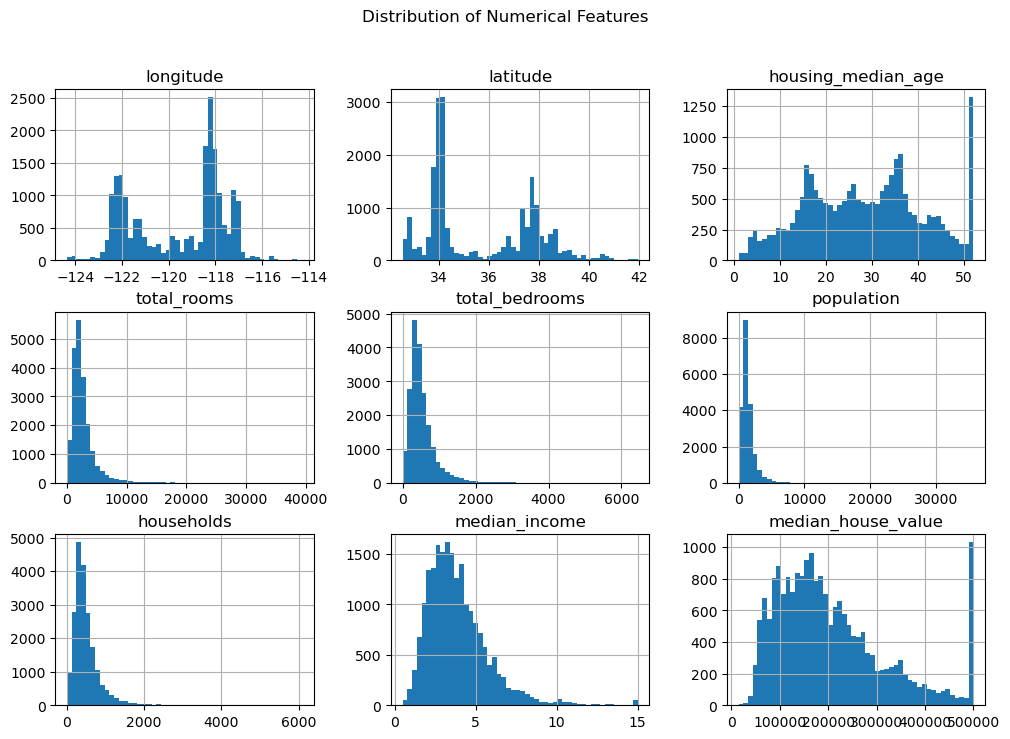

In [132]:
housing.hist(bins=50, figsize=(12, 8))
plt.suptitle("Distribution of Numerical Features")
plt.show()

In [133]:
# Step 2: Create income category for stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [134]:
# Perform stratified sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [135]:
# Remove income_cat column
for dataset in (strat_train_set, strat_test_set):
    dataset.drop("income_cat", axis=1, inplace=True)

In [136]:
# Copy the training set
housing = strat_train_set.copy()

In [137]:
# Step 4: Separate features and labels
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)

In [138]:
# Step 5: Define custom transformer for cluster similarity
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, input_features=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [139]:
# Define functions for ratio transformations
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return [f"{feature_names_in[0]}_per_{feature_names_in[1]}"]

def ratio_pipeline():
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("ratio", FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
        ("standardize", StandardScaler())
    ])

In [140]:
# Define log pipeline for numerical features
log_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ("standardize", StandardScaler())
])


In [141]:
# Define categorical pipeline
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [142]:
# Default numerical pipeline for remaining features
default_num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

In [143]:
# Step 5: Define custom transformer to add new features
class ExtraAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        X["rooms_per_house"] = X["total_rooms"] / X["households"]
        X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
        X["people_per_house"] = X["population"] / X["households"]
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(input_features + ['rooms_per_house', 'bedrooms_ratio', 'people_per_house'])

In [144]:
# Step 6: Update the preprocessing pipeline
preprocessing = Pipeline([
    ("attribs_adder", ExtraAttributesAdder()),
    ("column_transformer", ColumnTransformer([
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income",
                               "rooms_per_house", "bedrooms_ratio", "people_per_house"]),
        ("geo", ClusterSimilarity(random_state=42), ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ], remainder=default_num_pipeline))
])


In [145]:
# Step 7: Define the model pipeline with RandomForestRegressor
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

In [146]:
# Step 8: Define hyperparameter distributions for RandomizedSearchCV
param_distribs = {
    'preprocessing__column_transformer__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20)
}

In [147]:
# Step 9: Perform RandomizedSearchCV to find the best hyperparameters
rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('attribs_adder',
                                                               ExtraAttributesAdder()),
                                                              ('column_transformer',
                                                               ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                                            SimpleImputer(strategy='median')),
                                                                                                           ('standardize',
                                                                                                            StandardScaler())]),
                                                                                 transformers=[('log',
                                                                                                Pipeline(steps=[('impute',
                                                                                                                 SimpleImputer(strategy='median')),...
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__column_transformer__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FE5EC81040>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FE5EC80800>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [148]:
# Step 10: Evaluate the final model on the test set
final_model = rnd_search.best_estimator_

In [149]:
# Feature importances
feature_importances = final_model["random_forest"].feature_importances_
feature_names = final_model["preprocessing"].get_feature_names_out()
sorted_features = sorted(zip(feature_importances, feature_names), reverse=True)
print("Top 10 Feature Importances:")
for importance, name in sorted_features[:10]:
    print(f"{name}: {importance:.4f}")

Top 10 Feature Importances:
log__median_income: 0.1897
cat__ocean_proximity_INLAND: 0.0836
log__bedrooms_ratio: 0.0713
log__rooms_per_house: 0.0536
log__people_per_house: 0.0519
geo__Cluster 30 similarity: 0.0365
geo__Cluster 36 similarity: 0.0227
geo__Cluster 9 similarity: 0.0208
geo__Cluster 25 similarity: 0.0190
geo__Cluster 1 similarity: 0.0189


In [158]:
# Prepare the test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [160]:
# Make predictions on the test set
final_predictions = final_model.predict(X_test)

In [162]:
# Calculate RMSE
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f"\nFinal Model RMSE: {final_rmse:.2f}")


Final Model RMSE: 41295.93


C:\Users\tejes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [164]:
# Calculate 95% confidence interval for RMSE
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39140.11910885, 43344.64325846])